In [321]:
# import necessary packages
import sys
import os
import argparse
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, Add, Lambda, GaussianNoise
from tensorflow.keras.models import Model
print('TensorFlow version: ', tf.__version__)

def get_target_class_index(label):
    label = label.lower().replace('_', ' ')
    jsonPath = ('./imagenet_index.json')
    with open(jsonPath) as json_file:
        mapping_dict = json.load(json_file)
    return mapping_dict.get(label, None)    # default to None when Key not found

def preprocess_image(image):
	# swap color channels, resize the image, and add in a batch dimension
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    return image

def clip_eps(tensor, eps):
	# clip the values of input tensor to the range [-eps, eps]
	return tf.clip_by_value(tensor, clip_value_min = -eps, clip_value_max = eps)

def generate_target_adversaries(model, base_image, delta, original_class_index, target_class_index, steps, noise_tf):
	loss_list = [['step', 'loss','orig_loss', 'target_loss']]
	for step in range(0, steps):
		with tf.GradientTape() as tape:
			tape.watch(delta)
			mu, sigma = 0, 20
			noise = np.random.normal(mu, sigma, [1,224,224,3])
            # add our perturbation vector to the base image and preprocess the resulting image
			adversary = preprocess_input(base_image + delta)
			if noise_tf is True:
				adversary += noise
			# run this newly constructed image through the model and calculate the loss below
			predictions = model(adversary, training=False)
            # compute the negative sparse categorical cross-entropy loss with respect to the *original* class index
			originalLoss = sccLoss(tf.convert_to_tensor([int(original_class_index)]), predictions)
			#originalLoss_neg = -sccLoss(tf.convert_to_tensor([int(original_class_index)]), predictions)
			# print(originalLoss.numpy())
			# print(originalLoss_neg.numpy())
            # compute the positive sparse categorical cross-entropy loss with respect to the *target* class index
			targetLoss = sccLoss(tf.convert_to_tensor([int(target_class_index)]), predictions)
			# record the loss computation inside tape
			totalLoss = -originalLoss + targetLoss
			loss_list.append([step, totalLoss.numpy(), originalLoss.numpy(), targetLoss.numpy()])
			# display the loss every 10 steps
			if step % 25 == 0:
				print('step: {}, loss: {}'.format(step, totalLoss.numpy()))
			
        
		# calculate the gradients of loss with respect to the perturbation vector
		gradients = tape.gradient(totalLoss, delta)

		# update the weights, clip the perturbation vector, and update its value
		optimizer.apply_gradients([(gradients, delta)])
		delta.assign_add(clip_eps(delta, eps=epsilon))

	return delta, loss_list


# parse arguments from command line
# parser = argparse.ArgumentParser()
# parser.add_argument('file_in', help='input file name')
# parser.add_argument('target_class', help='target class name')
# args = parser.parse_args()





TensorFlow version:  2.12.0


In [322]:
target_class = 'beer glass'
file_in = 'input.jpg'

target_index = get_target_class_index(target_class)
if target_index == None:
    print('Error: Target class does not exist in ImageNet.')
    sys.exit(0)

print('Input Filename: ', file_in)
print('Target Class: ', target_class)
print('Target Class Index: ', target_index)

# preprocess the input image
input_image = preprocess_image(cv2.imread(file_in))
preprocessed_input = preprocess_input(input_image)

# load the pre-trained ResNet50 model with ImageNet weights
model = ResNet50(weights = 'imagenet')

# make predictions on the input image and return the top 3 results
mu, sigma = 0, 20
noise = np.random.normal(mu, sigma, [1,224,224,3])
predictions = model.predict(preprocessed_input)
noise_predictions = model.predict(preprocessed_input+noise)
predictions = decode_predictions(predictions, top=3)[0]
noise_predictions = decode_predictions(noise_predictions, top=3)[0]
print('Top 3 Predictions: ', predictions)
print('Top 3 Noise Predictions: ', noise_predictions)
original_label = predictions[0][1]
original_confidence = predictions[0][2]
original_index = get_target_class_index(original_label)
print('Original Class Index: ', original_index)

# # # define the epsilon, learning rate and step number values
epsilon = 0.01
learning_rate = 0.01
num_of_steps = 300

# initialize optimizer and loss function
optimizer = Adam(learning_rate = learning_rate)
sccLoss = SparseCategoricalCrossentropy()

# create a tensor based off the input image and initialize the perturbation vector (we will update this vector via training)
baseImage = tf.constant(input_image, dtype=tf.float32)
delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)
print('initial delta norm')
print(tf.norm(delta))

# generate the perturbation vector to create an adversarial example
nonoise_deltaUpdated, nonoise_loss_list = generate_target_adversaries(model, baseImage, delta, original_index, target_index, num_of_steps, False)
print('post nonoise delta norm')
tf.norm(delta)

import pickle

with open('nonoise_loss_list', 'wb') as f:
    pickle.dump(nonoise_loss_list, f)
    f.close()

# # create the adversarial example, swap color channels, and save the output image to disk
adverImage = (baseImage + nonoise_deltaUpdated).numpy().squeeze()
adverImage = np.clip(adverImage, 0, 255).astype('uint8')
adverImage = cv2.cvtColor(adverImage, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_300_nonoise.png', adverImage)

Input Filename:  input.jpg
Target Class:  beer glass
Target Class Index:  441
1/1 [==============================] - 0s 154ms/step
Top 3 Predictions:  [('n02395406', 'hog', 0.9992756), ('n02396427', 'wild_boar', 0.00045690412), ('n03935335', 'piggy_bank', 0.00021880098)]
Top 3 Noise Predictions:  [('n02395406', 'hog', 0.99131244), ('n03935335', 'piggy_bank', 0.00532025), ('n02396427', 'wild_boar', 0.0023279188)]
Original Class Index:  341
initial delta norm
tf.Tensor(0.0, shape=(), dtype=float32)
step: 0, loss: 23.31926727294922
step: 25, loss: 6.616311073303223
step: 50, loss: 1.2289962768554688
step: 75, loss: -3.3133111000061035
step: 100, loss: -8.585748672485352
step: 125, loss: -15.421655654907227
step: 150, loss: -22.383882522583008
step: 175, loss: -31.274866104125977
step: 200, loss: -44.28492736816406
step: 225, loss: -58.981414794921875
step: 250, loss: -72.10134887695312
step: 275, loss: -83.00299835205078
post nonoise delta norm


True

In [323]:
### NOISY ###

target_class = 'beer glass'
file_in = 'input.jpg'

target_index = get_target_class_index(target_class)
if target_index == None:
    print('Error: Target class does not exist in ImageNet.')
    sys.exit(0)

print('Input Filename: ', file_in)
print('Target Class: ', target_class)
print('Target Class Index: ', target_index)

# preprocess the input image
input_image = preprocess_image(cv2.imread(file_in))
preprocessed_input = preprocess_input(input_image)

# load the pre-trained ResNet50 model with ImageNet weights
model = ResNet50(weights = 'imagenet')

# make predictions on the input image and return the top 3 results
mu, sigma = 0, 20
noise = np.random.normal(mu, sigma, [1,224,224,3])
predictions = model.predict(preprocessed_input)
noise_predictions = model.predict(preprocessed_input+noise)
predictions = decode_predictions(predictions, top=3)[0]
noise_predictions = decode_predictions(noise_predictions, top=3)[0]
print('Top 3 Predictions: ', predictions)
print('Top 3 Noise Predictions: ', noise_predictions)
original_label = predictions[0][1]
original_confidence = predictions[0][2]
original_index = get_target_class_index(original_label)
print('Original Class Index: ', original_index)

# # # define the epsilon, learning rate and step number values
epsilon = 0.01
learning_rate = 0.01
num_of_steps = 300

# initialize optimizer and loss function
optimizer = Adam(learning_rate = learning_rate)
sccLoss = SparseCategoricalCrossentropy()

# create a tensor based off the input image and initialize the perturbation vector (we will update this vector via training)
baseImage = tf.constant(input_image, dtype=tf.float32)
delta1 = tf.Variable(tf.zeros_like(baseImage), trainable=True)
print('initial delta norm')
print(tf.norm(delta1))

deltaUpdated, loss_list = generate_target_adversaries(model, baseImage, delta1, original_index, target_index, num_of_steps, True)
print('post noise delta norm')
tf.norm(delta1)

with open('loss_list', 'wb') as f:
    pickle.dump(loss_list, f)
    f.close()


# # create the adversarial example, swap color channels, and save the output image to disk

adverImage1 = (baseImage + deltaUpdated).numpy().squeeze()
adverImage1 = np.clip(adverImage1, 0, 255).astype('uint8')
adverImage1 = cv2.cvtColor(adverImage1, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_300.png', adverImage1)

Input Filename:  input.jpg
Target Class:  beer glass
Target Class Index:  441
1/1 [==============================] - 0s 161ms/step
Top 3 Predictions:  [('n02395406', 'hog', 0.9992756), ('n02396427', 'wild_boar', 0.00045690412), ('n03935335', 'piggy_bank', 0.00021880098)]
Top 3 Noise Predictions:  [('n02395406', 'hog', 0.9887307), ('n03935335', 'piggy_bank', 0.007839666), ('n02396427', 'wild_boar', 0.0015201378)]
Original Class Index:  341
initial delta norm
tf.Tensor(0.0, shape=(), dtype=float32)
step: 0, loss: 18.04918670654297
step: 25, loss: 17.659809112548828
step: 50, loss: 19.414081573486328
step: 75, loss: 15.189547538757324
step: 100, loss: 17.287168502807617
step: 125, loss: 15.019881248474121
step: 150, loss: 14.798720359802246
step: 175, loss: 12.781044006347656
step: 200, loss: 12.998784065246582
step: 225, loss: 12.246319770812988
step: 250, loss: 9.295295715332031
step: 275, loss: 10.074256896972656
post noise delta norm


True

In [324]:
import matplotlib.pyplot as plt
import pandas as pd

h=nonoise_loss_list.pop(0)
nonoise_df = pd.DataFrame(data=nonoise_loss_list, columns=h)
h1=loss_list.pop(0)
df = pd.DataFrame(data=loss_list, columns=h1)

loss plots


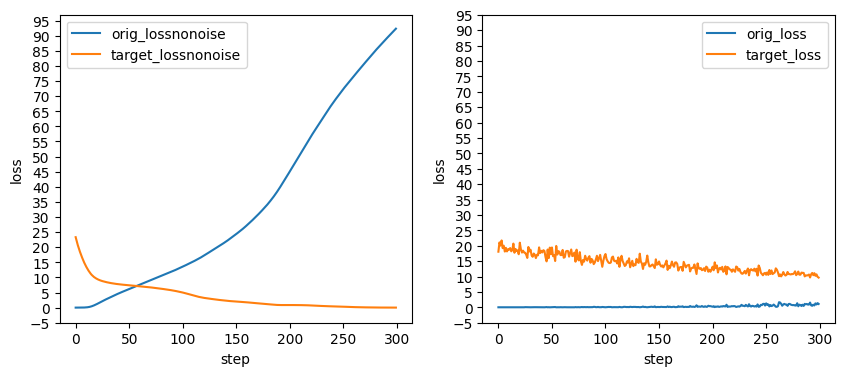

In [352]:
df3 = df.join(nonoise_df[['loss','orig_loss','target_loss']], rsuffix='nonoise')
fig,ax = plt.subplots(ncols=2, figsize=(10,4))

#'loss','lossnonoise',
for a in ['orig_loss','target_loss']:
    ax[1].plot(df3['step'],df3[a],label=a)
for a in ['orig_lossnonoise','target_lossnonoise']:
    ax[0].plot(df3['step'],df3[a],label=a)



ax[0].set_xlabel("step")
ax[0].set_ylabel("loss")
ax[0].legend(loc='best')
ax[0].set_yticks(np.arange(-5, 100, 5))

ax[1].set_xlabel("step")
ax[1].set_ylabel("loss")
ax[1].legend(loc='best')
ax[1].set_yticks(np.arange(-5, 100, 5))

print('loss plots')

In [327]:
print(tf.norm(deltaUpdated))
print(tf.norm(nonoise_deltaUpdated))
# 1269.2789 for no noise, # 1409 for noise -59 loss # 2680 with 600 and -63 loss
# 4802 with -100, 1200 steps

tf.Tensor(1231.0942, shape=(), dtype=float32)
tf.Tensor(1282.7448, shape=(), dtype=float32)


In [328]:
#predict off nonoise pertubated image
input_image = preprocess_image(cv2.imread('./output_300_nonoise.png'))
preprocessed_input = preprocess_input(input_image)
predictions = model.predict(preprocessed_input)

predictions = decode_predictions(predictions, top=3)[0]
print('Top 3 Predictions on Adversarial Image (No noise): ', predictions)
adv_label = predictions[0][1]
adv_confidence = predictions[0][2]

1/1 [==============================] - 0s 176ms/step
Top 3 Predictions on Adversarial Image (No noise):  [('n02823750', 'beer_glass', 0.9934277), ('n07892512', 'red_wine', 0.004561879), ('n03443371', 'goblet', 0.0019558598)]


In [346]:

import numpy as np 
mu, sigma = 0, 30
noise = np.random.normal(mu, sigma, [1,224,224,3])

#predict off adverse image created from noisy model
input_image = preprocess_image(cv2.imread('./output_300.png'))
preprocessed_input = preprocess_input(input_image)
predictions = model.predict(preprocessed_input+noise)

predictions = decode_predictions(predictions, top=3)[0]
#print('Top 3 Predictions on Adversarial Image (With Noise): ', predictions)
adv_label = predictions[0][1]
adv_confidence = predictions[0][2]
print(adv_label, adv_confidence)

1/1 [==============================] - 0s 245ms/step
hog 0.44024834
